In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
from collections import defaultdict

## Creating the Neural Network

In [2]:
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

## Creating the Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

## Creating the Training Class

In [4]:
class BlackjackDQL:
    # Hyperparameters (adjustable)
    learning_rate_a = 0.1  # learning rate (alpha)
    discount_factor_g = 0.9  # discount rate (gamma)
    network_sync_rate = 100  # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1500  # size of replay memory
    mini_batch_size = 32  # size of the training data set sampled from the replay memory

    loss_fn = nn.MSELoss()  # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None  # NN Optimizer. Initialize later.

    def train(self, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make('Blackjack-v1', render_mode='human' if render else None)
        num_states = 3
        num_actions = 2
        
        epsilon = 1
        memory = ReplayBuffer(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        # Policy network optimizer. "Adam" optimizer can be swapped to something else.
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = []

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count = 0
        for i in range(episodes):
            state = env.reset()  # Initialize to state 0
            done = False
            rewards = 0
                
            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while not done:

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample()
                else:
                    # select best action
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                new_state, reward, done, _ = env.step(action)

                # Accumulate reward
                rewards += reward

                # Save experience into memory
                memory.append((state, action, new_state, reward, done))

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count += 1

            # Keep track of the rewards collected per episode.
            rewards_per_episode.append(rewards)
            epsilon_history.append(epsilon)

            # Check if enough experience has been collected
            if len(memory) > self.mini_batch_size:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon - 1 / episodes, 0)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        # Close environment
        env.close()

        # Save the policy nn's weights and biases
        torch.save(policy_dqn.state_dict(), "resources\\blackjack_dql.pt")

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.plot(rewards_per_episode, color="orange", label="learning rate", linestyle="", marker="o")
        plt.legend()
        plt.savefig("resources\\learning_curve.png")

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.clf()
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon Value")
        plt.plot(epsilon_history, color="orange", label="epsilon decay")
        plt.legend()
        plt.savefig("resources\\epsilon_decay.png")

    def optimize(self, mini_batch, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                # Agent receive reward of 0 for reaching goal.
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state))
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state):
        return torch.FloatTensor([state[0], state[1], state[2]])

    # Run the FrozeLake environment with the learned policy
    def test(self, episodes):
        # Create FrozenLake instance
        env = gym.make('Blackjack-v1', render_mode='human')
        num_states = 3
        num_actions = 2

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("resources\\blackjack_dql.pt"))
        policy_dqn.eval()  # switch model to evaluation mode

        for i in range(episodes):
            state = env.reset()
            done = False

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while not done:
                # Select best action
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state, reward, done, _ = env.step(action)

        env.close()

## Main

C:\Users\Lau\miniconda3\envs\rlProjects3.7\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
C:\Users\Lau\miniconda3\envs\rlProjects3.7\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

defaultdict(<class 'int'>, {1.0: 7056, -1.0: 11763, 0.0: 1181})


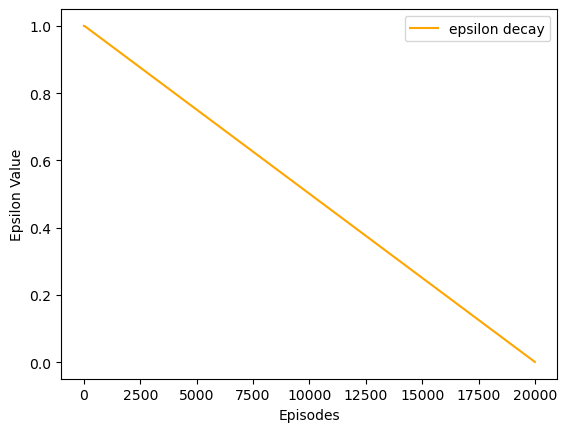

In [5]:
blackjack = BlackjackDQL()
blackjack.train(50000)
# blackjack.test(20)